Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Bayesian linear classifiers

In this example you are going to fit a Bayesian logistic regression model, using two sets of features on data $\mathbf{x} \in \mathbb{R}^2$:

$$\begin{align*}
\phi_{\text{simple}}(\mathbf{x}) &= [ 1, x_1, x_2 ] \\
\phi_{\text{polynomial}}(\mathbf{x}) &= [ 1, x_1, x_2, x_1x_2, x_1^2, x_2^2, x_1^3, x_2^3 ]
\end{align*}$$

and three types of estimation:

1. MAP estimation (penalized maximum likelihood)
2. Laplace approximation (a Gaussian approximate posterior, centered at the mode)
3. **for extra credit**, Variational Bayes (a Gaussian approximate posterior, found by maximizing a lower bound on the model "evidence", i.e. the marginal likelihood)

Here is a synthetic dataset that we'll be working with (plotting the training set only):

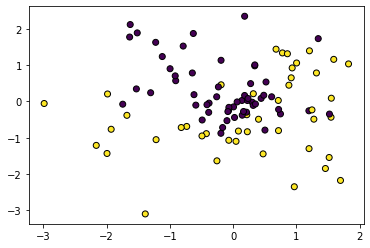

In [73]:
X_train, y_train, X_test, y_test = torch.load("data.pt")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='k');

Here are definitions of two different feature maps, the "simple" one and the "polynomial" one:

In [74]:
def features_simple(X):
    return torch.concat((torch.ones_like(X[:,:1]), X), -1)

def features_poly(X):
    interactions = X.prod(-1, keepdim=True)
    return torch.concat((torch.ones_like(X[:,:1]), 
                         X, X.pow(2), X.pow(3),
                         interactions), -1)


# TASK #1 (3 points): Define the model

The Bayesian logistic regression model we are working with has the form
$$\begin{align*}
\mathbf{w} &\sim \mathcal{N}(0, \sigma^2 \mathbf{I}) \\
\hat y_i &= \mathrm{Logistic}(\mathbf{w}^\top \phi(\mathbf{x}_i)) \\
y_i &\sim \mathrm{Bernoulli}(\hat y_i)
\end{align*}$$
where $i = 1,\dots, N$ and the Logistic function is defined
$$\begin{align*}
\mathrm{Logistic}(z) &= \frac{1}{1 + \exp\{-z\}}.
\end{align*}$$
It's implemented in pytorch as `torch.sigmoid`.

The first step is to define two functions, one to make predictions given a weight vector $\mathbf{w}$ and inputs $\Phi$, and one which computes the log joint probability

$$\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

I've done the first one for you.

In [75]:
def predict_probs_MAP(Phi, w):
    """
    Given a "design matrix" Phi, and a point estimate w, compute p(y = 1 | Phi, w)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w     : (D,) vector of weights

    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi, w)
    """
    return torch.sigmoid(Phi @ w)

In [76]:
def log_joint(Phi, y, w, sigma=10):
    """
    Compute the joint probability of the data and the latent variables.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w     : (D,) vector of weights
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    log_joint : the log probability log p(y, w | Phi, sigma), a scalar
        
    """

    # YOUR CODE HERE
    outputs = predict_probs_MAP(Phi, w)
    
    # we make the distributions
    y_dist = dist.Bernoulli(outputs)
    
    variance = sigma**2 * torch.eye(w.shape[0])
    w_dist = dist.MultivariateNormal(torch.zeros(w.shape).T, variance)
    
    # we compute the logprobs of each samples and add them to get the logjoint
    logjoint = torch.sum(y_dist.log_prob(y))

    logjoint += torch.sum(w_dist.log_prob(w.T))
    
    return logjoint

In [77]:
# (GRADING)

In [78]:
# (GRADING)

# TASK 2 (5 points): Implement MAP estimation

Now you need to write a function which performs MAP estimation, i.e. penalized maximum likelihood estimation.

This function should find the value $\mathbf{w}_{MAP}$ that maximizes the log joint, i.e.

$$\mathbf{w}_{MAP} = \mathrm{argmax}_{\mathbf{w}}\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}, \sigma^2).$$

To do this, you should **use pytorch autograd tools**. This will involve defining an initial value of the weights, computing a scalar loss function, and calling `.backward()`, and then performing gradient-based optimization. Take a look at the demo notebooks from previous lectures for examples…!

* You **may feel free to use classes from `torch.optim`**. I would suggest the use of `torch.optim.SGD` or `torch.optim.Adagrad`.
* Regardless of how you do this, you will need to decide on a stopping criteria for your optimization routine.
* You will also need to decide on how to set the parameters (learning rate, momentum, anything else!) for your selected optimizer.


In [79]:
def find_MAP(Phi, y):
    """
    Find the MAP estimate of the log_joint method.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones


    OUTPUT:
    w      : (D,) vector of optimized weights
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
    """

    weights = torch.zeros(Phi.shape[1]).requires_grad_(True)
    losses = []
    
    # YOUR CODE HERE
    
    # stealing code from the lectures
    opt = torch.optim.SGD((weights, ), lr=0.01, momentum=0.5)
    
    #define number of steps
    N_steps = 2000
    
    # we save the losses
    for n in range(N_steps):
        
        # we reset gradients for each step
        opt.zero_grad()
        
        # we compute log likelihood with the current weights
        # we want to maximise the likelihood i.e. minimize the loss
        loss = -log_joint(Phi, y, weights)
        
        # we get the gradients
        loss.backward()
        
        # we append our losses for each run
        losses.append(loss.item())
        
        # we step 
        opt.step()
        
        # we define a stopping criterion, in 32bit tensors, equality is achieved very fast, we can put a strict criterion
        # requires equality over 10 last runs
        if n > 10:
            if losses[n]==losses[n-5] and losses[n-5]==losses[n-10]:
                break
                print("stopped after", n, "steps" )
    
    return weights.detach(), losses


### The following two cells call `find_MAP` to compute $\mathbf{w}$ for both choices of features.

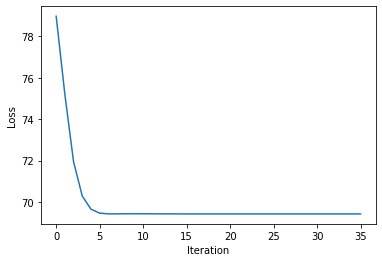

In [80]:
w_MAP_simple, losses = find_MAP(features_simple(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

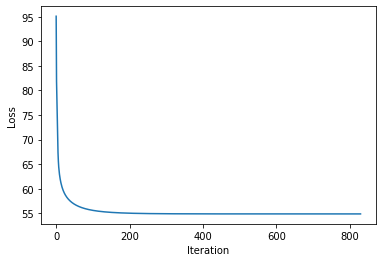

In [81]:
w_MAP_poly, losses = find_MAP(features_poly(X_train), y_train)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

In [82]:
# (GRADING)

In [83]:
# (GRADING)

## Visualization: The following code visualizes the classifier result

It plots the probability of being one class or the other using a color contour plot.

The decision boundary is a dashed black line.

In [84]:
def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8, levels=np.linspace(0, 1, 8))
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

Simple features: training accuracy = 0.68, test accuracy = 0.68


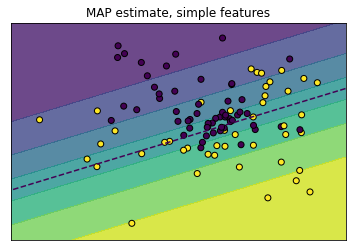

In [85]:
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))
plt.title("MAP estimate, simple features")
train_accuracy = (predict_probs_MAP(features_simple(X_train), w_MAP_simple).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_simple(X_test), w_MAP_simple).round() == y_test).float().mean()
print("Simple features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

Polynomial features: training accuracy = 0.86, test accuracy = 0.92


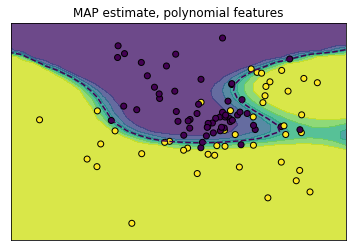

In [86]:
plot_boundary(X_train, y_train,
              lambda X: predict_probs_MAP(features_poly(X), w_MAP_poly))
plt.title("MAP estimate, polynomial features")
train_accuracy = (predict_probs_MAP(features_poly(X_train), w_MAP_poly).round() == y_train).float().mean()
test_accuracy = (predict_probs_MAP(features_poly(X_test), w_MAP_poly).round() == y_test).float().mean()
print("Polynomial features: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

# TASK #3 (5 points): Laplace approximation

In the next section, you will fit an approximate posterior over the weights by using the Laplace approximation around the mode $\mathbf{w}_{MAP}$ of the distribution you found above.

This requires completing two functions:

1. `compute_laplace_Cov` takes the data and the MAP estimate, and outputs a covariance matrix defined as the negative inverse Hessian of the log target density. (See the week 4 lecture slides for details on how to compute this!)
2. `predict_bayes` makes predictions on new data points, by approximating $\int p(y | x, w)p(w | \mathcal{D})dw$ when using a Gaussian approximation to $p(w | \mathcal{D})$. In the week 4 lecture slides we discussed three different ways of computing this — it is up to you to decide what method you would prefer, and implement it.

In [87]:
def compute_laplace_Cov(Phi, y, w_MAP, prior_std=10):
    """
    Compute the Laplace approximation of the posterior covariance 
    in a logistic regression setting.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    sigma : scalar, standard deviation of Gaussian prior distribution p(w).
            Leave this set to sigma=10 for purposes of this exercise

    OUTPUT:
    Cov : (D, D) posterior covariance matrix estimate defined by the Laplace 
          approximation
    """
    
    # YOUR CODE HERE
    # vectorising the creation of the covariance matrix
    
    y_hat = torch.sigmoid(w_MAP@Phi.T)
    
    summation = Phi.T@((y_hat*(1-y_hat)) * torch.eye(y.shape[0]))@Phi
    
    inv_variance = prior_std**(-2) * torch.eye(w_MAP.shape[0])
    
    big_S = inv_variance + summation
    
    return torch.inverse(big_S)

In [88]:
def predict_bayes(Phi, w_MAP, Cov):
    """
    Make predictions on new data points using an approximate posterior 
    w ~ MultivariateNormal(w_MAP, Cov)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    y_hat : (N,) vector of probabilities p(y=1 | Phi)
    """
    
    # YOUR CODE HERE
    # we choose a number of samples
    N = 1000
    sample_size = torch.Size((N,1))
    
    #we create our distribtion
    w = dist.MultivariateNormal(w_MAP, Cov)
    
    #we sample from the distribution
    mc_sample = w.sample(sample_size)
    
    expectation = 1/N * torch.sum(torch.sigmoid(mc_sample@Phi.T), axis=0) 

    y_hat = expectation
    
    return y_hat.T

### The following cells call your functions above to compute the Laplace approximation and visualize the posterior predictive distribution.

In [89]:
Cov_simple = compute_laplace_Cov(features_simple(X_train), y_train, w_MAP_simple)

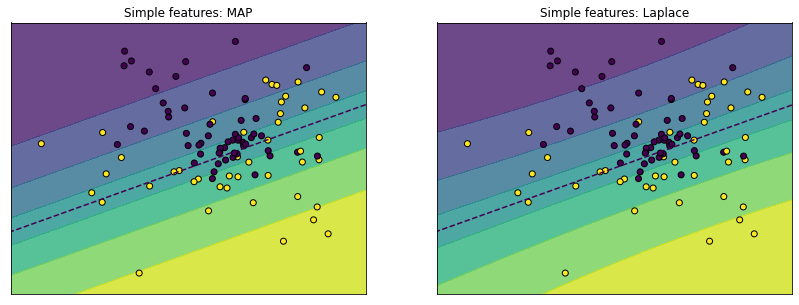

In [90]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Simple features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_simple(X), w_MAP_simple))

plt.subplot(122)
plt.title("Simple features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_simple(X), w_MAP_simple, Cov_simple))

In [91]:
Cov_poly = compute_laplace_Cov(features_poly(X_train), y_train, w_MAP_poly)

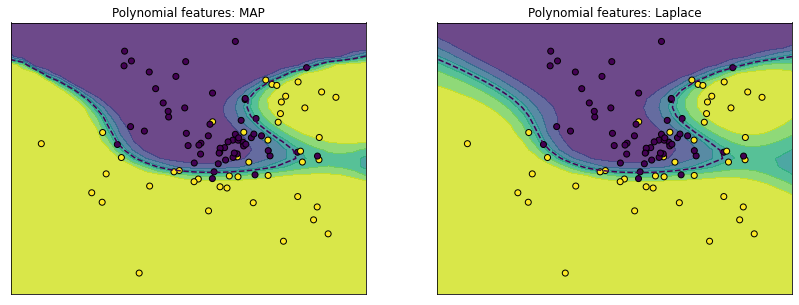

In [92]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Polynomial features: MAP")
plot_boundary(X_train, y_train, 
              lambda X: predict_probs_MAP(features_poly(X), w_MAP_poly))

plt.subplot(122)
plt.title("Polynomial features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_poly(X), w_MAP_poly, Cov_poly))

In [93]:
# (GRADING)

In [94]:
# (GRADING)

In [95]:
# (GRADING)

# TASK #4 (2 points): Model comparison

You can compute the marginal likelihood approximation defined by the Laplace approximation.

This estimate of the evidence can be used, even just looking at the training data, to help decide which of the two feature maps is more appropriate and better fits the data.

This can help guard against potential overfitting if using features that are "too complex".

In [96]:
def compute_laplace_log_evidence(Phi, y, w_MAP, Cov):
    """
    This computes the Laplace approximation to the marginal likelihood,
    as defined in the Week 5 lectures.
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    w_MAP : (D,) vector of optimized weights, at a mode of the target density
    Cov   : (D, D) approximate posterior covariance matrix
    
    OUTPUT:
    log_evidence : scalar value estimating `log p(y | Phi)`
    """
    
    # YOUR CODE HERE
    logjoint = log_joint(Phi, y, w_MAP)
    
    log_evidence = (logjoint
                    + w_MAP.shape[0]/2 * np.log(2*np.pi) 
                    + 0.5*torch.log((torch.det(Cov)))
    )
    
    return log_evidence

In [97]:
print("Model evidence estimate (simple features):",
      compute_laplace_log_evidence(features_simple(X_train), y_train, w_MAP_simple, Cov_simple).item())

print("Model evidence estimate (polynomial features):",
      compute_laplace_log_evidence(features_poly(X_train), y_train, w_MAP_poly, Cov_poly).item())

Model evidence estimate (simple features): -70.93085479736328
Model evidence estimate (polynomial features): -52.30986404418945


In [98]:
# (GRADING)

# EXTRA CREDIT TASK #5 (6 points): Variational Bayes

For the Variational Bayes approach, we define an evidence lower bound (ELBO)

$$\mathcal{L}(\mathbf{\Phi}, \mathbf{y};\mathbf{\mu}, \mathbf{\Sigma}) = E_{q(\mathbf{w} | \mathbf{\mu}, \mathbf{\Sigma})}[\log p(\mathbf{y}, \mathbf{w} | \mathbf{\Phi}) - \log q(\mathbf{w} | \mathbf{\mu}, \mathbf{\Sigma})]$$

which we then can optimize, using gradient-based methods, to find optimal values of $\mathbf{\mu}^\star, \mathbf{\Sigma}^\star$ that make $$q(\mathbf{w} | \mathbf{\mu}, \mathbf{\Sigma}) \approx p(\mathbf{w} | \mathbf{\Phi}, \mathbf{y}).$$

To do this, you should implement
* `ELBO`, which returns a Monte Carlo estimate of the ELBO. This is not a deterministic function! It will require sampling from the approximate posterior $q(\mathbf{w} | \mathbf{\mu}, \mathbf{\Sigma})$.
* `estimate_VB`, which will be similar to the `find_MAP` function you wrote in part 2 — except instead of maximizing the log joint with respect to $\mathbf{w}$, it will maximize the ELBO with respect to $\mathbf{\mu}, \mathbf{\Sigma}$.

The marking for this section is:
* 2 points for implementing `ELBO` correctly, where $\mathbf{\Sigma}$ is a diagonal covariance matrix
* 2 points for implementing `estimate_VB` correctly, where $\mathbf{\Sigma}$ is a diagonal covariance matrix
* 2 bonus points if $\mathbf{\Sigma}$ is a full-rank $D \times D$ covariance matrix, instead

In [113]:
def ELBO(Phi, y, mu, Cov):
    """
    Return a Monte Carlo estimate of the evidence lower bound (ELBO)
    
    INPUT:
    Phi   : (N, D) tensor of input features, where N is the number of 
            observations and D is the number of features
    y     : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
            containing zeros and ones
    mu    : (D,) vector of variational parameters, indicating the 
            estimated posterior mean
    Cov   : (D, D) matrix of variational parameters, indicating the 
            estimated posterior covariance matrix
    
    OUTPUT:
    ELBO : scalar value estimating the ELBO
    """
    
    # YOUR CODE HERE
    
    # we choose a number of samples
    N = 100
    ELBO = 0
    # we create our proposal distribtion
    q_proposal = dist.MultivariateNormal(mu, Cov.tril() @ Cov.tril().T + 0.01 * torch.eye(Cov.shape[0]))
    
    for n in range(N):
        
        #we sample from the distribution
        w = q_proposal.rsample()

        logpro = log_joint(Phi, y, w)

        prop_prob = q_proposal.log_prob(w)

        ELBO += logpro - prop_prob
   
    return ELBO/N

In [114]:
def estimate_VB(Phi, y, mu_init):
    """
    Return a Monte Carlo estimate of the evidence lower bound (ELBO)
    
    INPUT:
    Phi     : (N, D) tensor of input features, where N is the number of 
              observations and D is the number of features
    y       : (N,) vector of outputs (targets). Should be a `torch.FloatTensor`
              containing zeros and ones
    mu_init : (D,) initial value of the variational parameters for the
              posterior mean.

            
    OUTPUT:
    mu     : (D,) vector of variational parameters, indicating the 
             estimated posterior mean
    Cov    : (D, D) matrix of variational parameters, indicating the 
             estimated posterior covariance matrix
    losses : list of losses at each iteration of the optimization algorithm.
             Should be a list of scalars, which can be plotted afterward to
             diagnose convergence.
   
    """

    # YOUR CODE HERE
    
    mu = mu_init.requires_grad_(True)
    Cov = (0.01*torch.randn(Phi.shape[1],Phi.shape[1])).requires_grad_(True)
    
    params = [mu, Cov]
    
    opt = torch.optim.Adagrad(params, lr=0.1)
    
    losses = []

    for N in range(300):
        
        opt.zero_grad()
        
        Elbow = ELBO(Phi, y, mu, Cov)
        
        loss = -Elbow
        
        loss.backward()
        
        losses.append(loss.item())
        
        opt.step()
        
    return mu, Cov.tril() @ Cov.tril().T + 0.01 * torch.eye(Cov.shape[0]), losses

### Estimate VB parameters, and plot the result (comparing to the Laplace approximation)

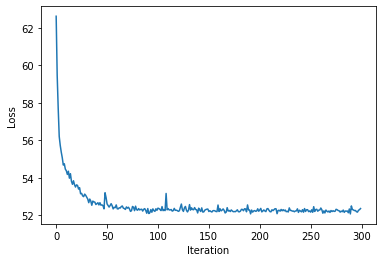

In [115]:
w_VB_poly, Cov_VB_poly, losses = estimate_VB(features_poly(X_train), y_train, mu_init=w_MAP_poly)
plt.plot(losses);
plt.xlabel("Iteration")
plt.ylabel("Loss");

Polynomial features, VB: training accuracy = 0.51, test accuracy = 0.50


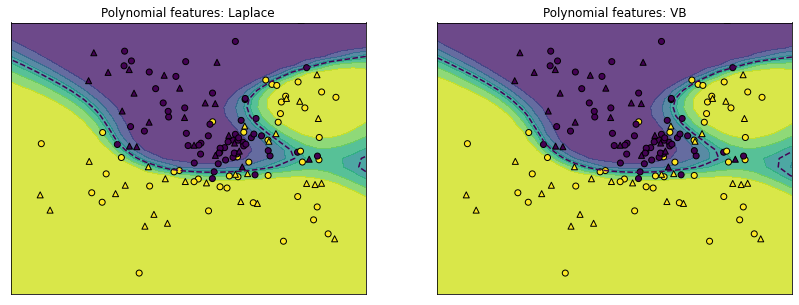

In [116]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title("Polynomial features: Laplace")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_poly(X), w_MAP_poly, Cov_poly))

plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='^', edgecolor='k');

plt.subplot(122)
plt.title("Polynomial features: VB")
plot_boundary(X_train, y_train, 
              lambda X: predict_bayes(features_poly(X), w_VB_poly, Cov_VB_poly))

plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='^', edgecolor='k');


train_accuracy = (predict_bayes(features_poly(X_train), w_VB_poly, Cov_VB_poly).round() == y_train).float().mean()
test_accuracy = (predict_bayes(features_poly(X_test), w_VB_poly, Cov_VB_poly).round() == y_test).float().mean()
print("Polynomial features, VB: training accuracy = %0.2f, test accuracy = %0.2f" % (train_accuracy, test_accuracy))

In [117]:
# (GRADING)

In [33]:
# (GRADING)

In [34]:
# (GRADING)

In [35]:
# (GRADING)